# EEG BCI Dataset Analysis

This notebook analyzes EEG data from a BCI competition dataset, focusing on Event-Related Potential (ERP) analysis for target vs non-target stimuli.

In [ ]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

### Data Loading

In [4]:
# Load the dataset
data = loadmat('datasetII/Subject_A_Train.mat')

# Extract main variables
Signal = data['Signal']
Flashing = data['Flashing']
StimulusCode = data['StimulusCode']
StimulusType = data['StimulusType']

# Display dataset info
print("Dataset keys:", list(data.keys()))
print(f"\nSignal shape: {Signal.shape}")
print(f"Flashing shape: {Flashing.shape}")
print(f"StimulusCode shape: {StimulusCode.shape}")
print(f"StimulusType shape: {StimulusType.shape}")


Dataset keys: ['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType']

Signal shape: (85, 7794, 64)
Flashing shape: (85, 7794)
StimulusCode shape: (85, 7794)
StimulusType shape: (85, 7794)


In [24]:
# print(Signal)
# print(Flashing)
# print(StimulusCode)
# print(StimulusType)


### Visualize raw EEG signal and signal type

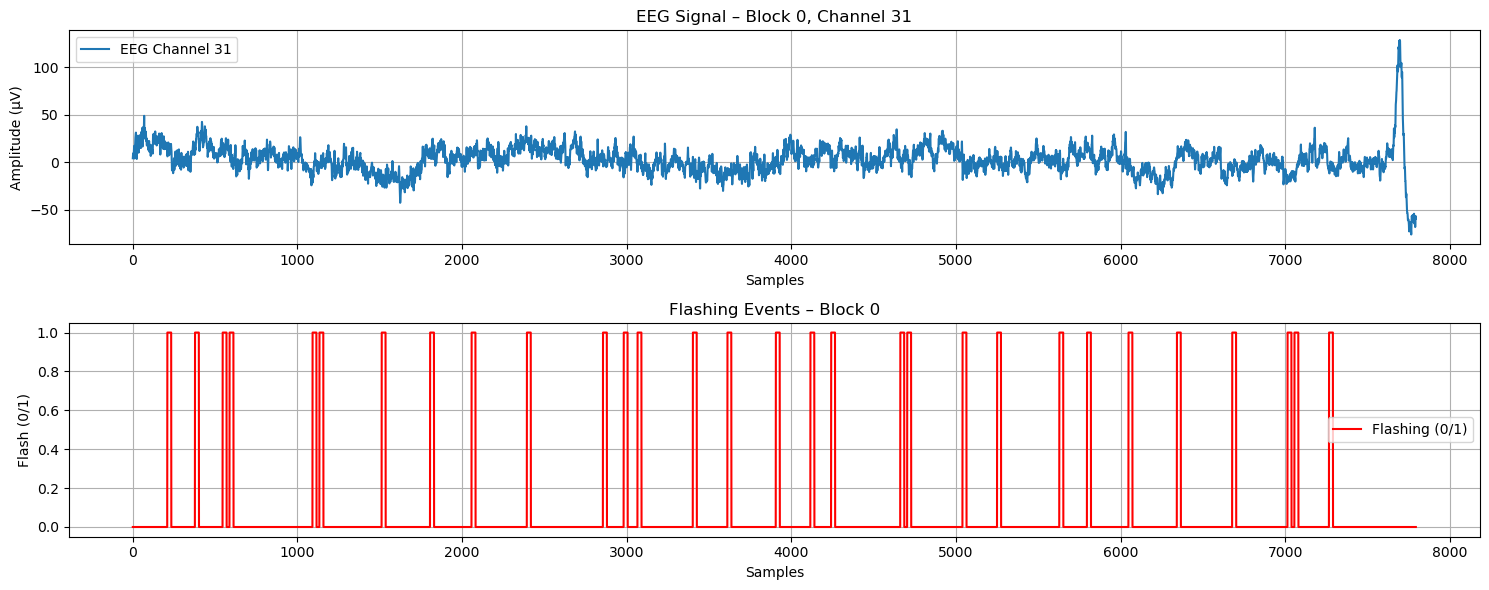

In [ ]:
block = 0
channel = 31

sig = Signal[block]
sigType = StimulusType[block]

plt.figure(figsize=(15, 6))

# EEG Channel
plt.subplot(2, 1, 1)
plt.plot(sig[:, channel], label=f'EEG Channel {channel}')
plt.title(f'EEG Signal – Block {block}, Channel {channel}')
plt.xlabel('Samples')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.legend()

# Signal Type
plt.subplot(2, 1, 2)
plt.plot(sigType, color='red', label='Type (0/1)')
plt.title(f'Signal Type – Block {block}')
plt.xlabel('Samples')
plt.ylabel('Type (0/1)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### ERP Analysis

Extract epochs around flashing events and compute Event-Related Potentials (ERPs) for target vs non-target stimuli.

In [ ]:
fs = 240.0        
t_pre = 0.1       
t_post = 0.7    

samples_pre = int(t_pre * fs)
samples_post = int(t_post * fs)
win_len = samples_pre + samples_post

sig = Signal          
flash = Flashing     
stype = StimulusType 

n_blocks, n_samples, n_ch = sig.shape
print("Blocks:", n_blocks, "Samples:", n_samples, "Channels:", n_ch)

target_sum = np.zeros((win_len, n_ch), dtype=np.float64)
nontarget_sum = np.zeros((win_len, n_ch), dtype=np.float64)
target_count = 0
nontarget_count = 0

for blk in range(n_blocks):
    f = flash[blk]

    onsets = np.where((f[1:] == 1) & (f[:-1] == 0))[0] + 1
    if f[0] == 1:
        onsets = np.r_[0, onsets]

    for i in onsets:
        start = i - samples_pre
        end = i + samples_post

        if start < 0 or end > n_samples:
            continue

        epoch = sig[blk, start:end, :].astype(np.float64)  # (win_len, n_ch)

        baseline = epoch[:samples_pre, :].mean(axis=0, keepdims=True)
        epoch = epoch - baseline

        if stype[blk, i] == 1:   # Target
            target_sum += epoch
            target_count += 1
        else:                    # Non-target
            nontarget_sum += epoch
            nontarget_count += 1

print("Target count:", target_count)
print("Nontarget count:", nontarget_count)

target_avg = target_sum / target_count
nontarget_avg = nontarget_sum / nontarget_count

Blocks: 85 Samples: 7794 Channels: 64
Target count: 2537
Nontarget count: 12678


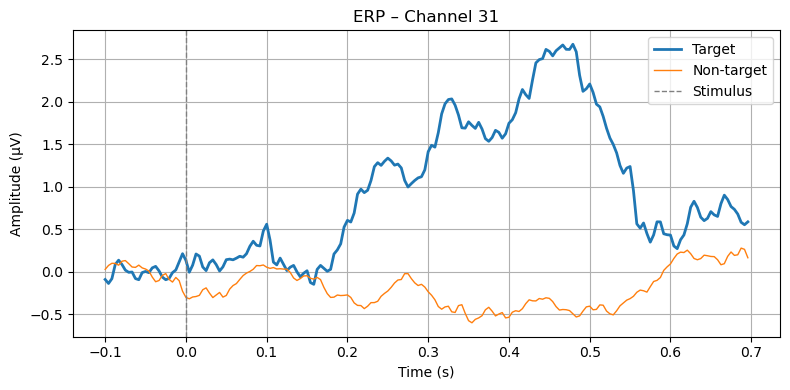

In [24]:
# Visualize ERP for a selected channel
channel = 31
time = np.linspace(-t_pre, t_post, win_len, endpoint=False)

plt.figure(figsize=(8, 4))
plt.plot(time, target_avg[:, channel], label='Target', linewidth=2)
plt.plot(time, nontarget_avg[:, channel], label='Non-target', linewidth=1)
plt.axvline(0, linestyle='--', color='gray', linewidth=1, label='Stimulus')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title(f'ERP – Channel {channel}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
